In [43]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  7 11:24:13 2024

@author: mrsag
"""

import yt
import numpy as np
import matplotlib.pyplot as plt
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from scipy.signal import fftconvolve
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

import matplotlib as mpl


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
#mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi']=300 # highres display


In [44]:
c = 0.3   #in mm/ps

def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index

def moving_average(signal, window_size):
    # Define the window coefficients for the moving average
    window = np.ones(window_size) / float(window_size)
    
    # Apply the moving average filter using fftconvolve
    filtered_signal = fftconvolve(signal, window, mode='same')
    
    return filtered_signal


def point_avg(arr,n):
    arr1=[]
    for i in range(int(len(arr)/n)):
        x=np.mean(arr[n*i:n*(i+1)])
        arr1.append(x)
    arr1.append(np.mean(arr[(int(len(arr)/n))*n:]))
    
    return(arr1)


def fill_zeros_with_neighbor_avg(arr, max_iterations=1000, tol=1e-10):
    arr = arr.copy()
    for _ in range(max_iterations):
        prev_arr = arr.copy()
        for i in range(len(arr)):
            if arr[i] == 0:
                # Find nearest non-zero to the left
                left = i - 1
                while left >= 0 and arr[left] == 0:
                    left -= 1

                # Find nearest non-zero to the right
                right = i + 1
                while right < len(arr) and arr[right] == 0:
                    right += 1

                left_val = arr[left] if left >= 0 else None
                right_val = arr[right] if right < len(arr) else None

                if left_val is not None and right_val is not None:
                    arr[i] = (left_val + right_val) / 2
                elif left_val is not None:
                    arr[i] = left_val
                elif right_val is not None:
                    arr[i] = right_val
                # if both are None (all zeros), do nothing

        # Break if the array stops changing
        if np.allclose(arr, prev_arr, atol=tol):
            break

    return arr


def fill_zeros_recursively(arr):
    arr = arr.copy().astype(float)
    n = len(arr)
    i = 0

    while i < n:
        if arr[i] != 0:
            start = i
            i += 1
            while i < n and arr[i] == 0:
                i += 1
            end = i
            if end < n and end - start > 1:
                left = arr[start]
                right = arr[end]
                gap = end - start - 1
                temp = [0] * gap
                for step in range((gap + 1) // 2):
                    val = (left + right) / (2 ** (step + 1))
                    temp[step] = val
                    temp[gap - 1 - step] = val
                arr[start + 1:end] = temp
        else:
            i += 1
    return arr

In [45]:

files = glob.glob("D:\\data Lab\\400 vs 800 doppler experiment\\400 pump 400 probe\\14th Feb 2024\\Spectrum\\run7\\*.txt")
#files = glob.glob("D:\\data Lab\\400 vs 800 doppler experiment\\800 pump 400 probe\\5th feb 2024\\spectrum\\5Feb23_Doppler_FS_Front\\Run9_70%_20TW_ret_11-15_250fs\\*.txt")
#files = glob.glob("D:\\data Lab\\400 vs 800 doppler experiment\\800 pump 400 probe\\5th feb 2024\\spectrum\\5Feb23_Doppler_FS_Front\\Run8_30%_20TW_ret_11-15_250fs\\*.txt")

delay = np.linspace(9.5,13.5,len(files)//2)-10.5
delay = 2*delay/c
delay = np.around(delay, decimals=3)

peaks = []

# for i in range(1,len(files),2):
#     f = open(files[i])
#     r=np.loadtxt(f,skiprows=17,comments='>')
    
#     wavelength = r[:,0]
#     intensity = r[:,1]
#     intensity /= max(intensity)
    
#     minw = find_index(wavelength, 392)
#     maxw = find_index(wavelength, 400)
    
#     wavelength = wavelength[minw:maxw]
#     intensity = intensity[minw:maxw] 

#     intensity -= np.mean(intensity[0:50])
    
#     fit_I,parameters,string = Gf.Gaussfit(wavelength, intensity)
#     peaks.append(parameters[1])
    
#     plt.plot(wavelength, intensity, 'r-', label = "data")
#     plt.plot(wavelength, fit_I, 'b-', label = " Gauss fit")
#     plt.title(files[i][-9:]+"\n"+f"Delay: {delay[i]}")
#     #plt.xlim(400,420)
#     plt.xlabel("Wavelength\n"+f"Peak:  {parameters[1]}")
#     plt.ylabel("Intensity")
#     plt.show()  

for i in range(1,len(files),2):
    f = open(files[i])
    r=np.loadtxt(f,skiprows=17,comments='>')
    
    wavelength = r[:,0]
    intensity = r[:,1]
    
    
    minw = find_index(wavelength, 390)
    maxw = find_index(wavelength, 400)
    
    wavelength = wavelength[minw:maxw]
    intensity = intensity[minw:maxw] 
    
    intensity -= np.mean(intensity[0:50])
    intensity /= max(intensity)
    fit_I,parameters,string = Gf.Gaussfit(wavelength, intensity)
    peaks.append(parameters[1])
    
    # plt.plot(wavelength, intensity, '-', label = "data")
    # plt.plot(wavelength, fit_I, 'b-', label = " Gauss fit")
    # plt.title(files[i][-9:]+"\n"+f"Delay: {delay[i]}")
    # plt.xlim(400,420)
    # plt.xlabel("Wavelength\n"+f"Peak:  {parameters[1]}")
    # plt.ylabel("Intensity")
    # plt.show()    
    
for i in range(len(peaks)):
    if (peaks[i]<395 or peaks[i]>396):
        try:
            peaks[i] = (peaks[i+1]+peaks[i-1])/2
        except:
            peaks[i] = 395.35

peaks = moving_average(peaks,10)

for i in range(len(peaks)):
    if (peaks[i]<395 or peaks[i]>396):
        try:
            if((peaks[i-1]<395 and peaks[i+1]>396) or (peaks[i+1]<395 and peaks[i+1]>396)):
                peaks[i] = (peaks[i+1]+peaks[i-1])/2
            else:
                peaks[i] = 395.35
        except:
            peaks[i] = 395.35

delay = delay[0:len(peaks)]

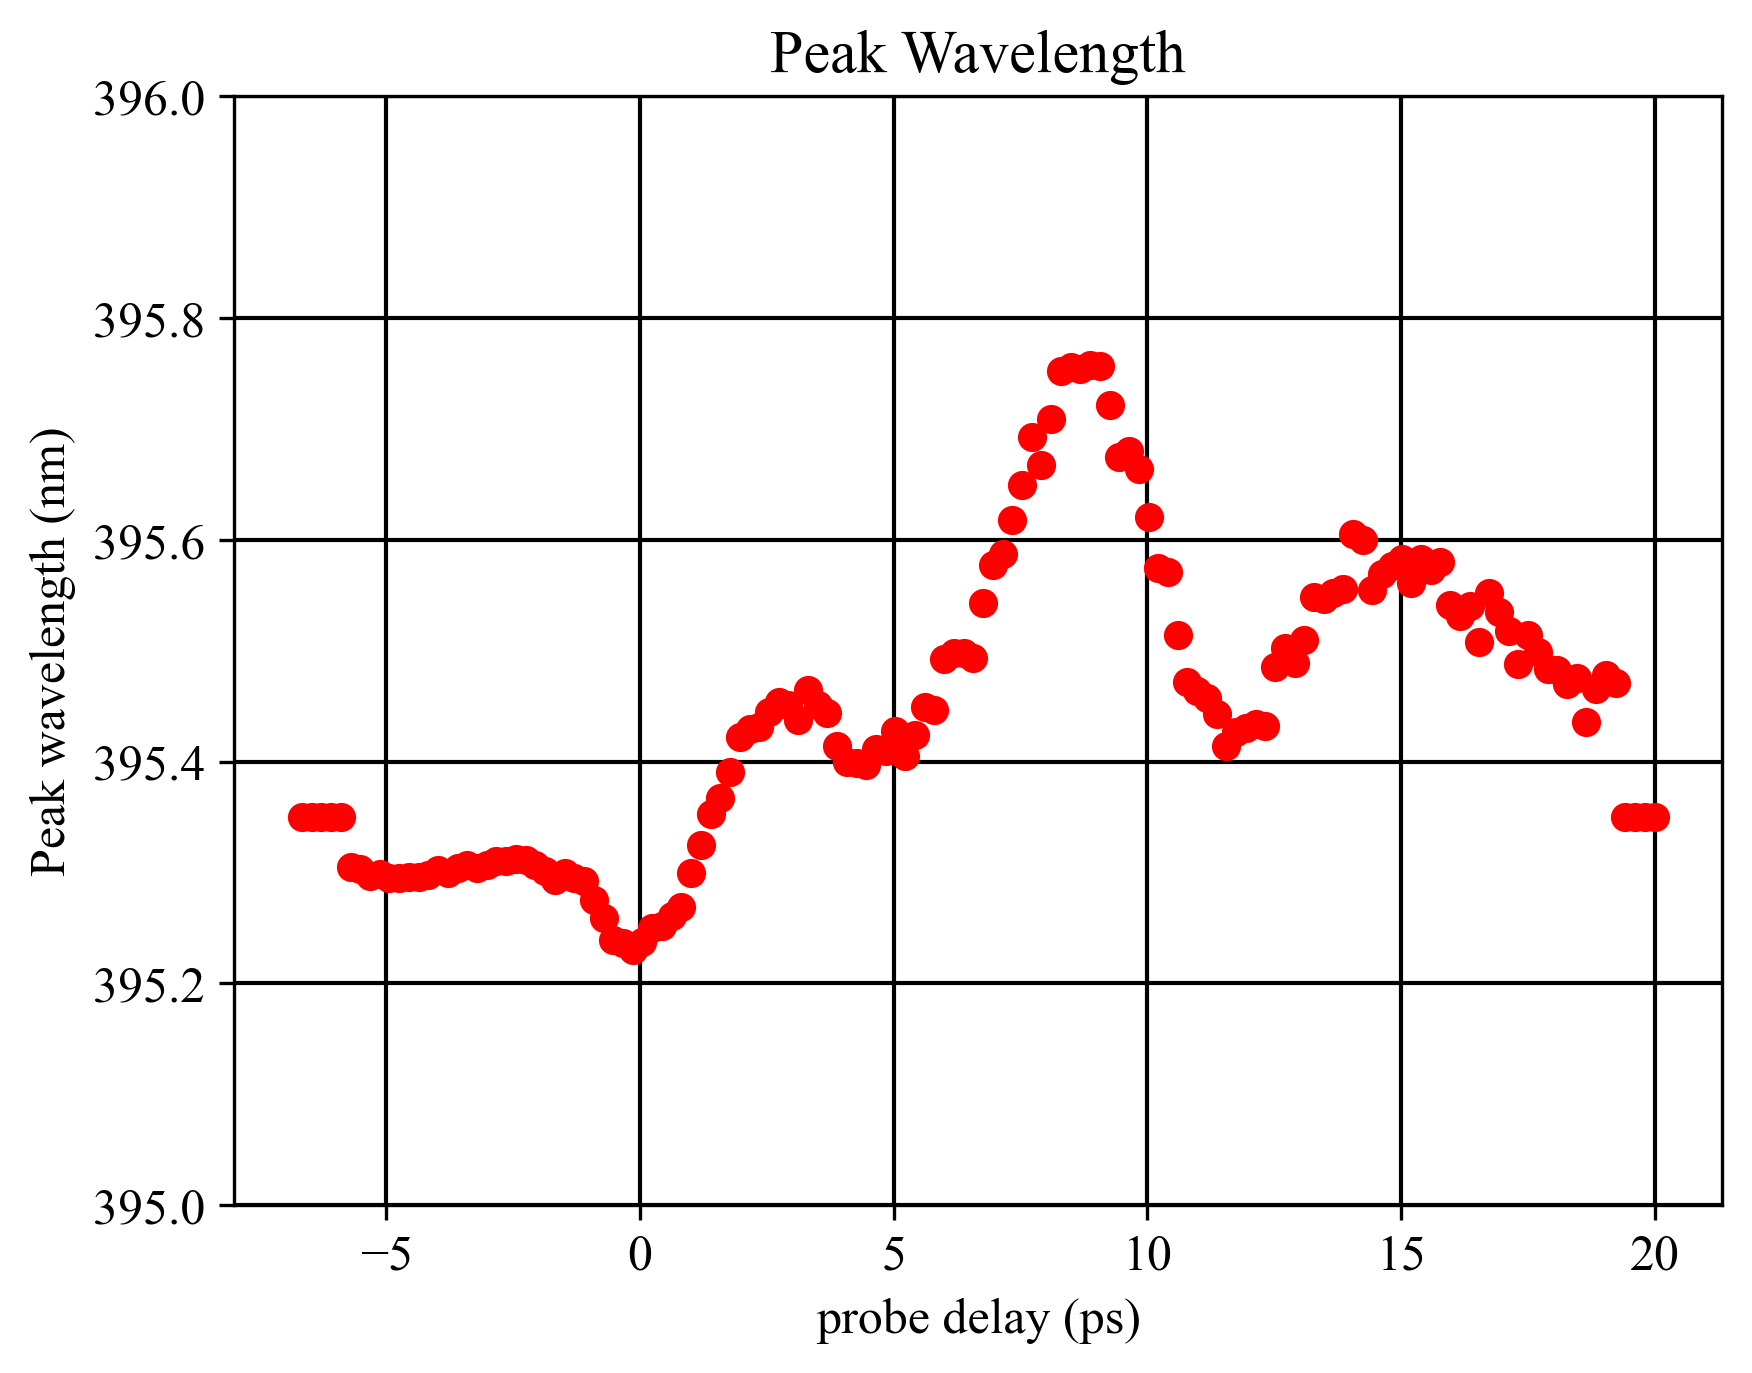

In [46]:

plt.plot(delay[0:len(peaks)],peaks, 'ro')
plt.title("Doppler shift")
plt.xlabel("probe delay (ps)")
plt.ylabel("Peak wavelength (nm)")
#plt.xlim(-2,max(delay))
plt.ylim(395,396)
plt.title("Peak Wavelength")
plt.grid(lw = 1, color = "black")
plt.show()


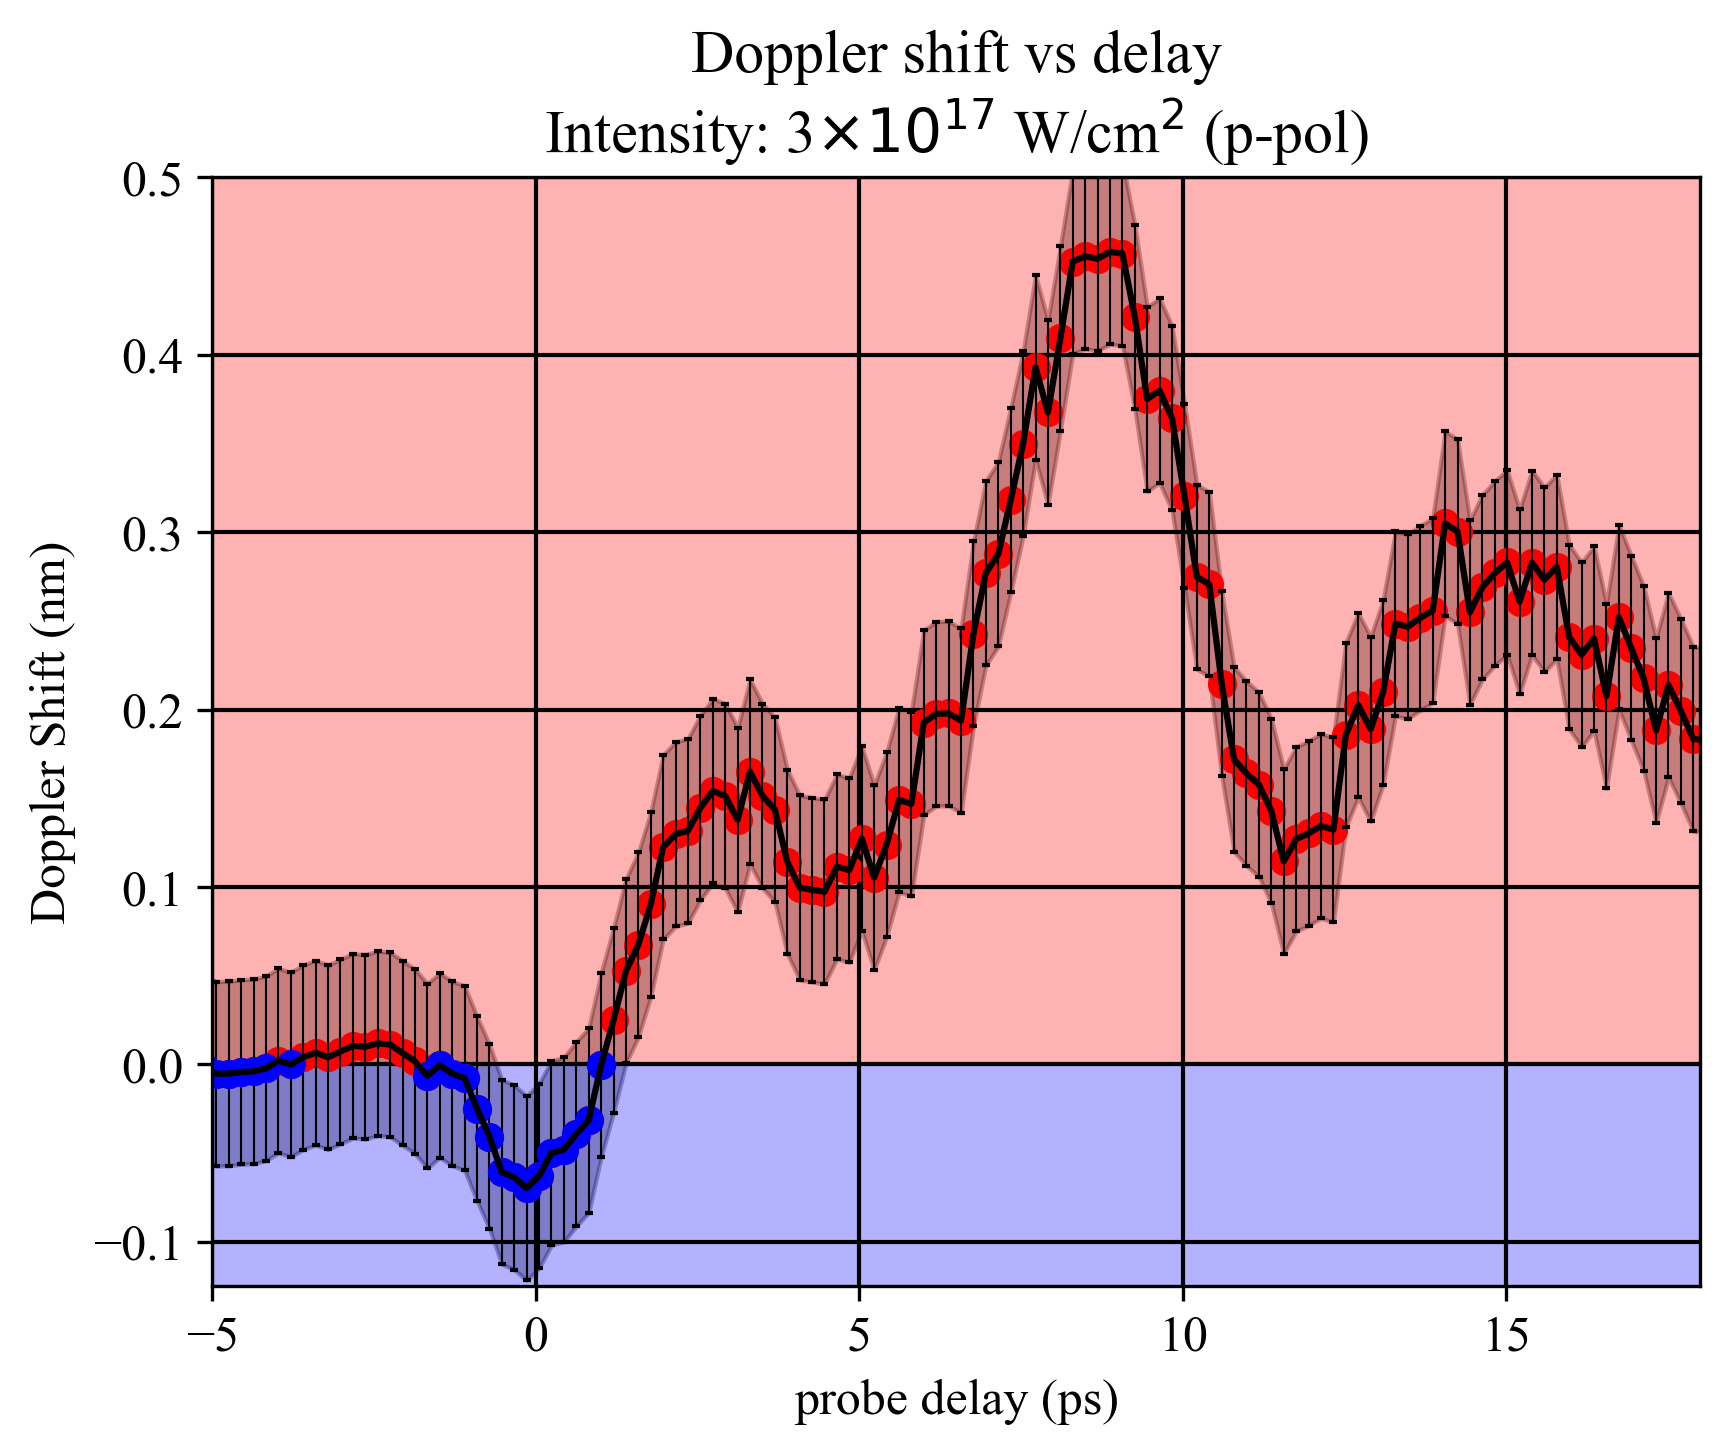

In [47]:

# plt.figure(figsize=(18,6))
plt.plot(delay[0:len(peaks)],peaks-395.3, 'ro')
plt.errorbar(x=delay[0:len(peaks)],y=peaks-395.3,yerr=np.ones(len(peaks))*0.052, color='k', capsize=1, linewidth=0.5)
plt.plot((delay[0:len(peaks)])[peaks-395.3<=0],peaks[peaks-395.3<=0]-395.3, 'bo')
plt.plot(delay[0:len(peaks)],peaks-395.3, 'k-')
plt.fill_between(delay[0:len(peaks)],peaks-395.3-0.052,peaks-395.3+0.052,color="k",alpha=0.3)
plt.title("Doppler shift")
plt.xlabel("probe delay (ps)")
plt.ylabel("Doppler Shift (nm)")
plt.xlim(-5,18)
plt.ylim(-0.125,0.5)
plt.title("Doppler shift vs delay\n"+fr"Intensity: 3$\times$"+r"$10^{17}$ W/cm$^2$ (p-pol)")
plt.grid(lw = 1, color = "black")
# Generate sample data
x = np.linspace(min(delay), max(delay), 100)
y1 = np.ones(len(x))*0.55
y2 = -np.ones(len(x))*0.15

# Set background colors based on y-values
plt.fill_between(x, y2, where=(y2 <= 0), color='blue', alpha=0.3)
plt.fill_between(x, y1, where=(y1 > 0), color='red', alpha=0.3)
plt.xticks()
plt.yticks()
plt.show()


In [48]:

peaks = peaks[find_index(delay,-5):find_index(delay, 18)]
delay = delay[find_index(delay,-5):find_index(delay, 18)]

# def calc_vel(w, w0):
#     c_norm = -3e10
#     v = (w**2-w0**2)/(w**2+w0**2)*c_norm
#     return v

def calc_vel(w, w0):
    c_norm = 3e10
    v = -0.5*(w-w0)/w*c_norm
    return v

lambda0 = np.mean(peaks[0:5])


velocity = calc_vel(np.array(peaks), lambda0)

blue_v = []
red_v = []

blue_delay = []
red_delay= []

for i in range(len(velocity)):
    if(velocity[i]<=0):
        blue_delay.append(delay[i])
        blue_v.append(velocity[i])
        
    else:
        red_delay.append(delay[i])
        red_v.append(velocity[i])
        
blue_v=np.array(blue_v)
red_v=np.array(red_v)


v_uerr = np.abs(calc_vel(w=peaks+0.064, w0=lambda0)-velocity)
v_lerr = np.abs(velocity-calc_vel(w=peaks-0.064, w0=lambda0))
x_uerr = np.ones(len(delay))*1
x_lerr = np.ones(len(delay))*1

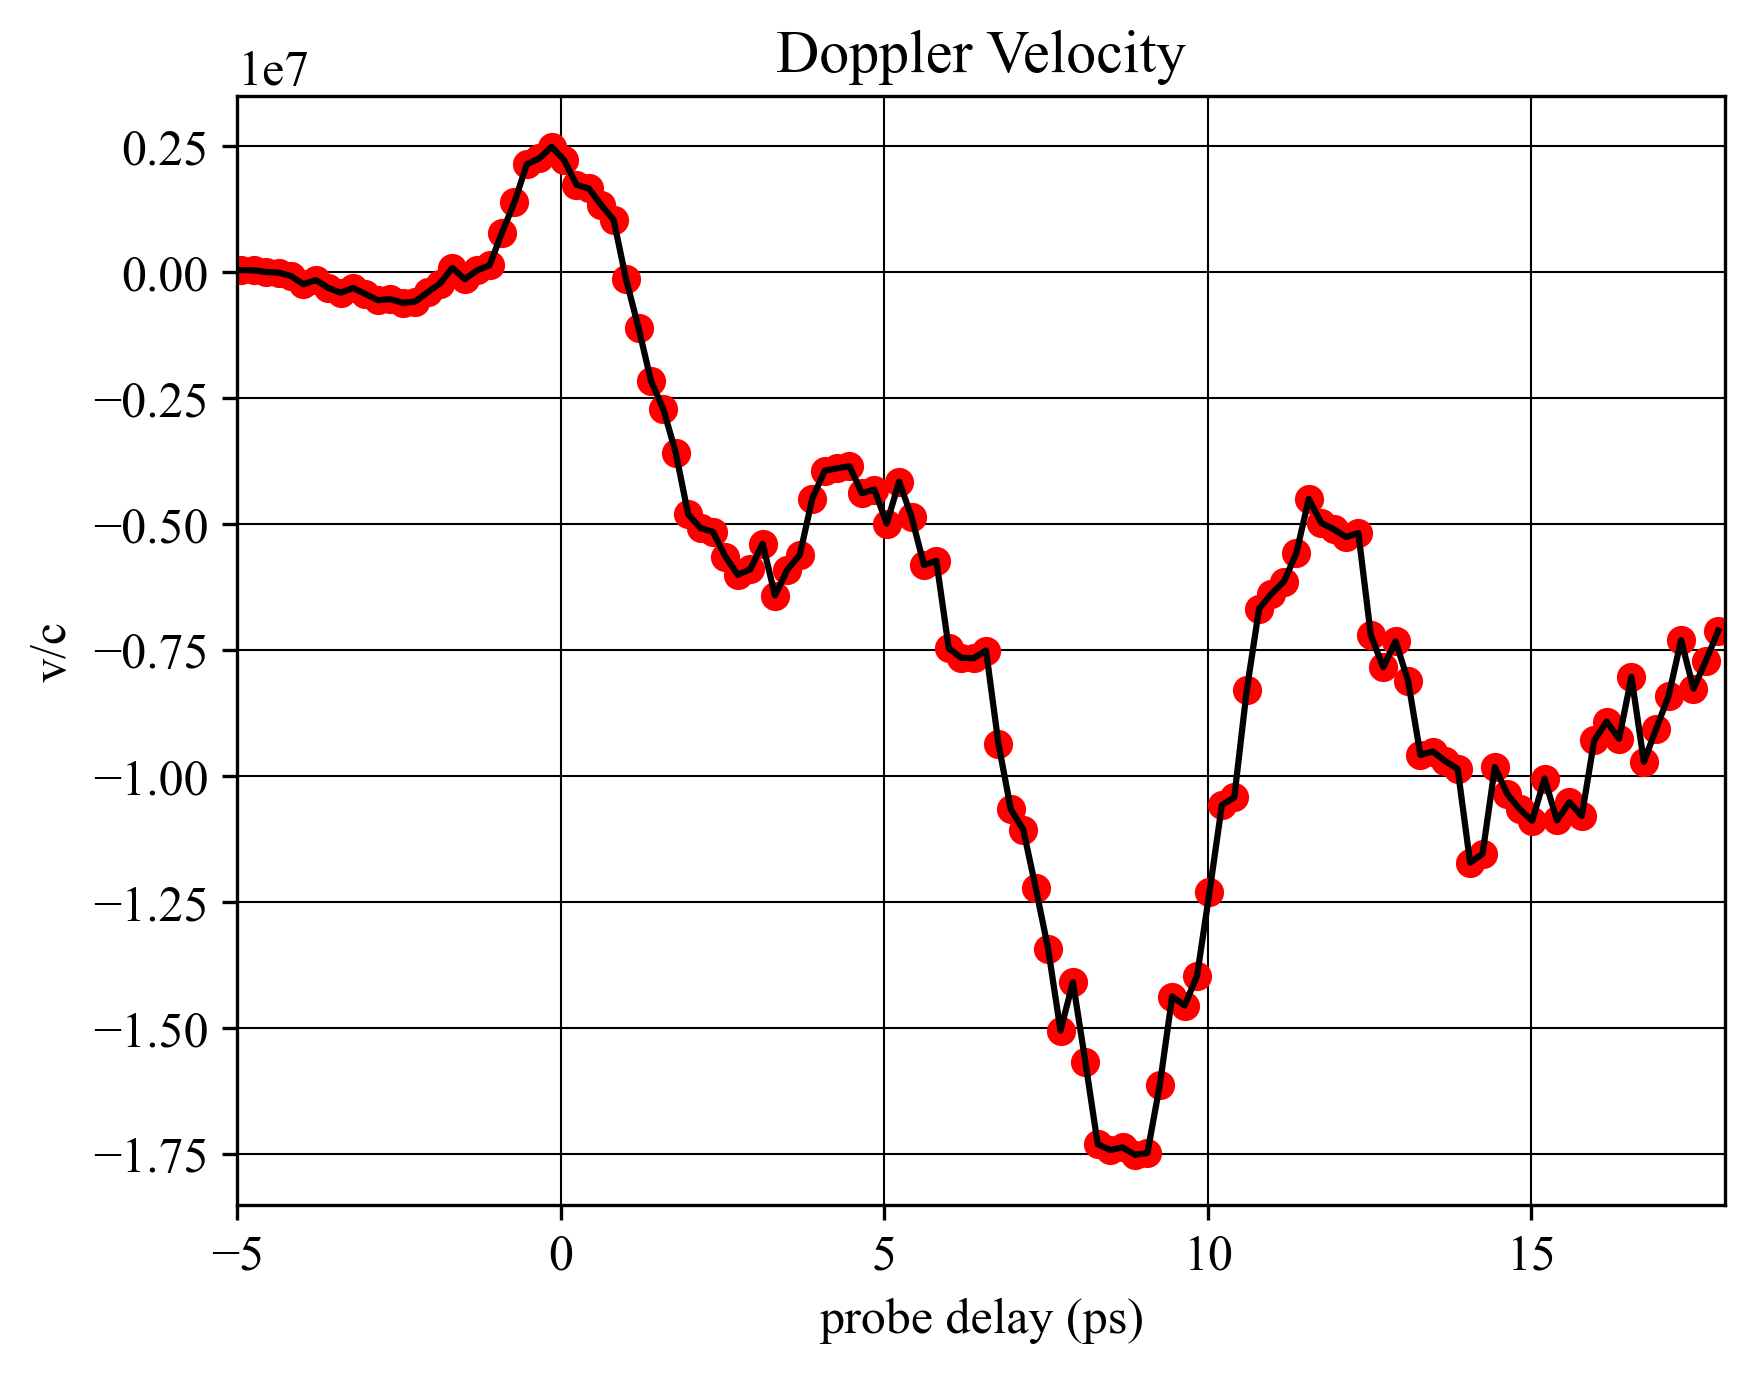

In [49]:

plt.plot(delay,velocity, 'ro')
plt.plot(delay,velocity, 'k-')
plt.title("Doppler Velocity")
plt.xlabel("probe delay (ps)")
plt.ylabel("v/c")
plt.xlim(-5,18)
#plt.ylim(-0.125,0.5)
plt.grid(lw = 0.5, color = "black")
plt.show()

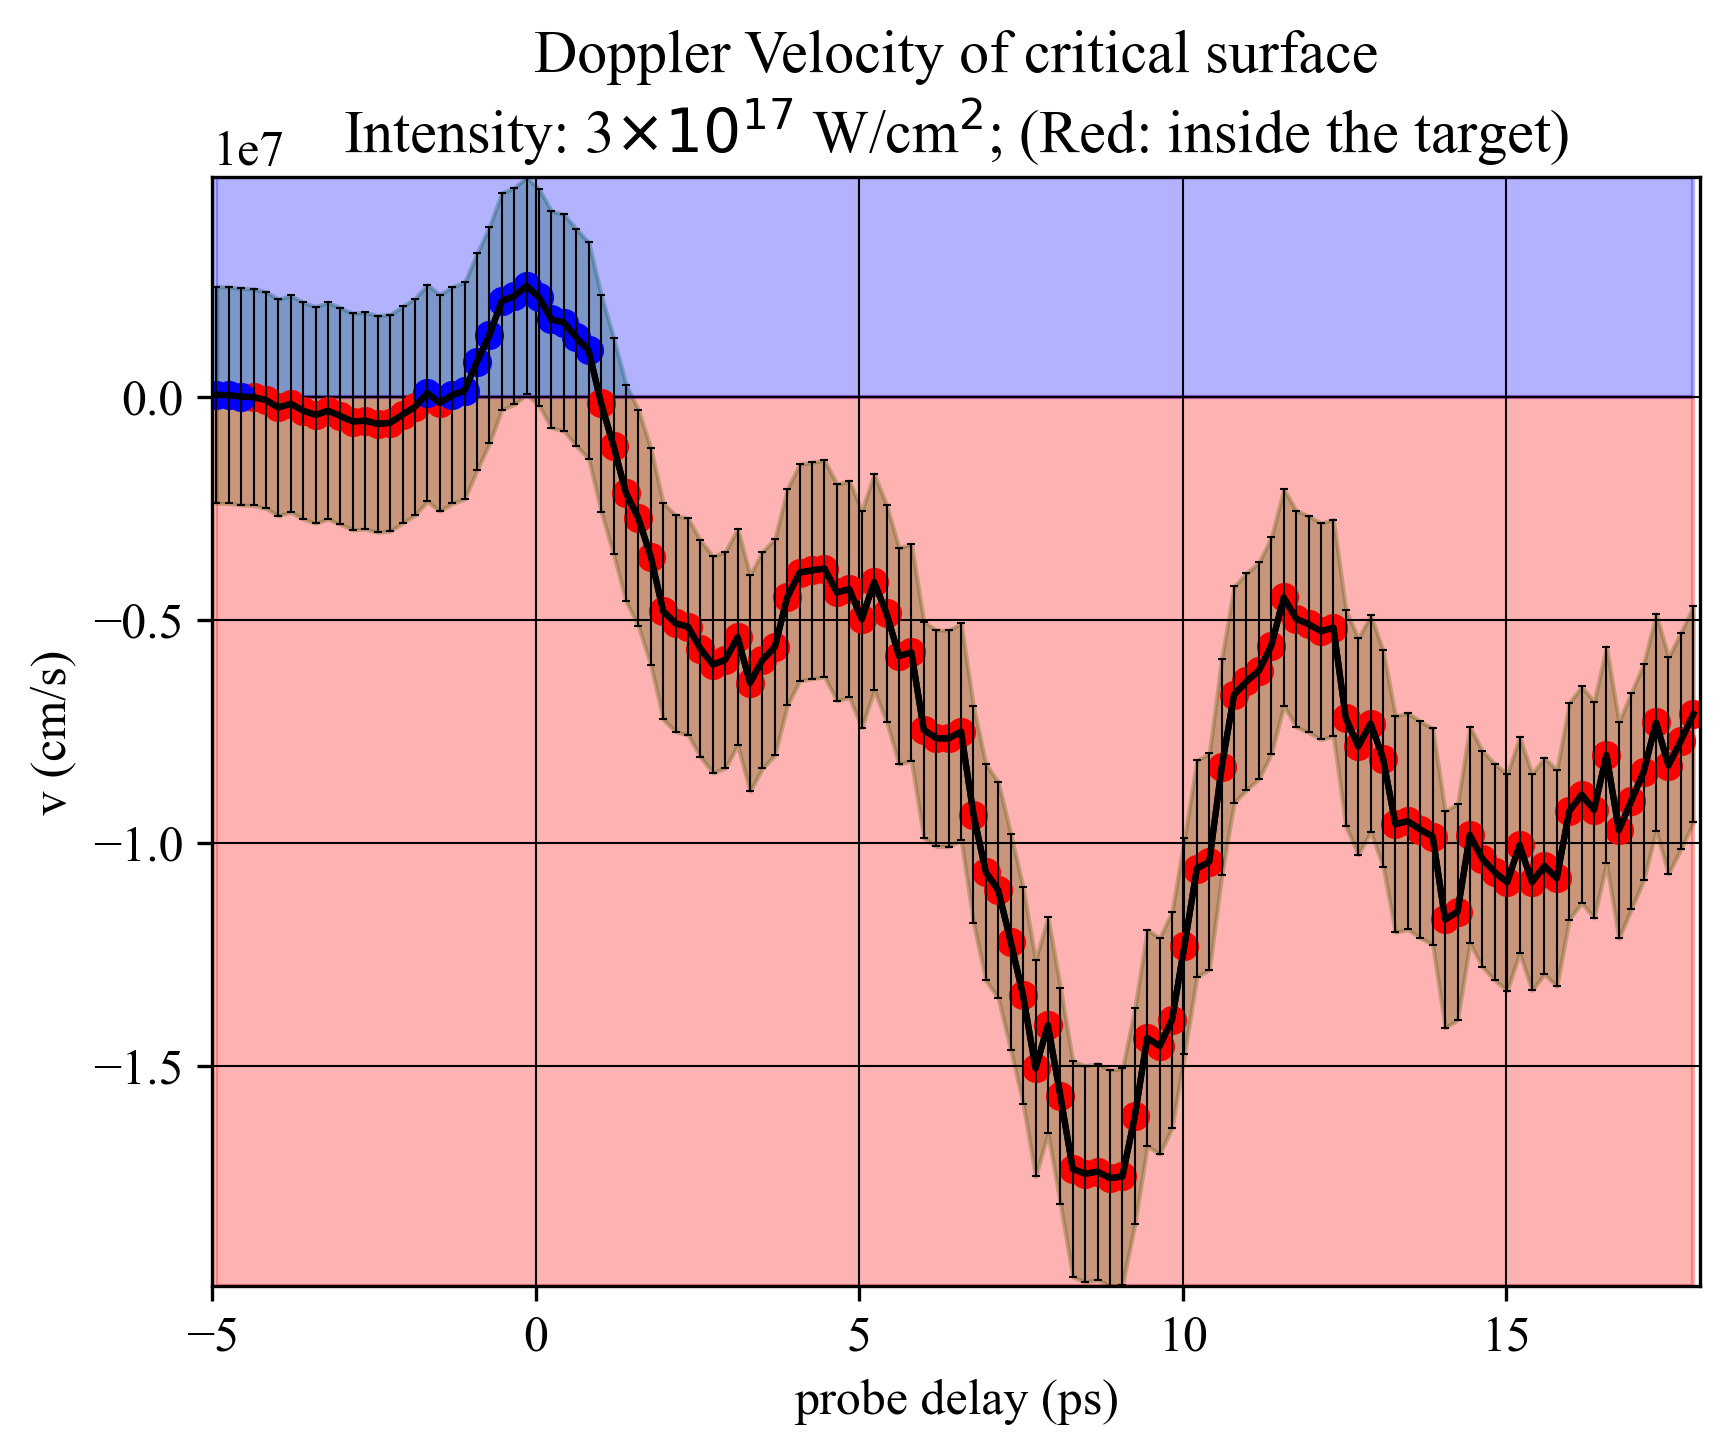

In [50]:

# plt.figure(figsize=(18,6))
plt.plot(blue_delay,blue_v, 'ro')
plt.plot(red_delay,red_v, 'bo')
plt.plot(delay,velocity, 'k-')
plt.errorbar(x=delay, y=np.array(velocity), yerr=[v_lerr,v_uerr], elinewidth=0.5, capsize=1, capthick=0.5, color = 'k')
#plt.errorbar(x=delay, y=np.array(velocity), xerr=[x_lerr,x_uerr], elinewidth=0.5, capsize=1, capthick=0.5, color = 'k')
plt.title("Doppler Velocity of critical surface\n"+fr"Intensity: 3$\times$"+r"$10^{17}$ W/cm$^2$"+"; (Red: inside the target)")
plt.xlabel("""probe delay (ps)""")
# plt.ylabel(r"$\beta$ (v/c)", size = 8)
plt.fill_between(delay,velocity+v_uerr,velocity-v_lerr,color="g",alpha=0.3)
plt.ylabel(r"v (cm/s)")
plt.xlim(-5,18)
plt.xticks()
plt.yticks()
#plt.ylim(-0.125,0.5)


# Generate sample data
x = np.linspace(min(delay), max(delay), 100)
y1 = np.ones(len(x))*(max(velocity)+max(v_uerr))
y2 = np.ones(len(x))*(min(velocity)-min(v_lerr))

# Set background colors based on y-values
plt.fill_between(x, y2, where=(y2 <= 0), color='red', alpha=0.3)
plt.fill_between(x, y1, where=(y1 > 0), color='blue', alpha=0.3)

plt.ylim((min(velocity-v_lerr)),(max(velocity+v_lerr)))

plt.grid(lw = 0.5, color = "black")
plt.show()


yt : [INFO     ] 2025-04-22 16:13:34,217 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-04-22 16:13:34,218 Parameters: domain_dimensions         = [32  1  1]
yt : [INFO     ] 2025-04-22 16:13:34,219 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-04-22 16:13:34,221 Parameters: domain_right_edge         = [5.e-04 1.e+00 1.e+00]
yt : [INFO     ] 2025-04-22 16:13:34,222 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-04-22 16:13:34,545 Parameters: current_time              = 1.0871767399302642e-13
yt : [INFO     ] 2025-04-22 16:13:34,545 Parameters: domain_dimensions         = [32  1  1]
yt : [INFO     ] 2025-04-22 16:13:34,545 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-04-22 16:13:34,546 Parameters: domain_right_edge         = [5.e-04 1.e+00 1.e+00]
yt : [INFO     ] 2025-04-22 16:13:34,546 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-04-22 16:13:34,872 Parameters: current_time    

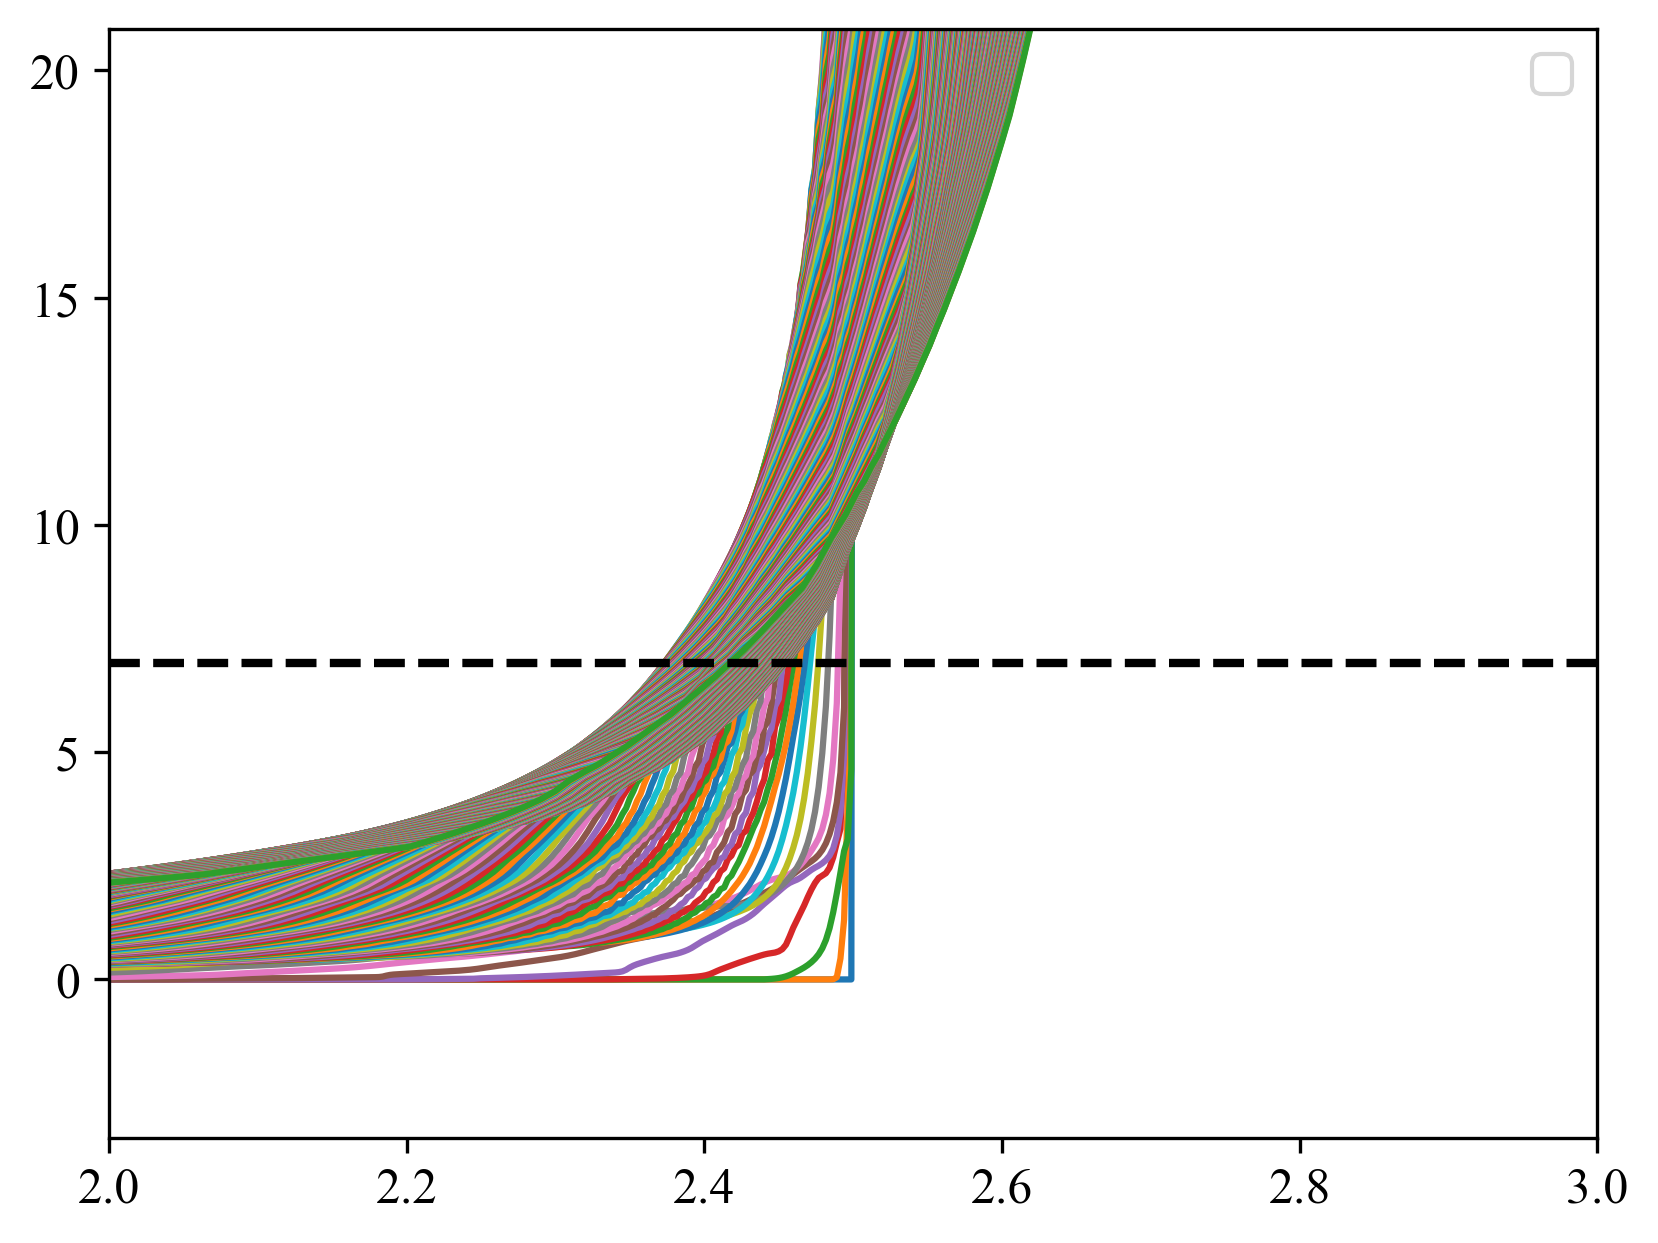

In [51]:
#####################################################################
# Simulation
######################################################################


# Load the dataset

files = glob.glob(r"D:\data Lab\400 vs 800 doppler experiment\Simulation with Jian\Hydro simulation 3e17 and 1e18 till 30 ps\TIFR_hydro_30ps\TIFR_1D_2_3e17_2\tifr_hdf5_plt_cnt_*")

pos = []

for file in files:
    ds = yt.load(file)
    # Create a data object (like the entire domain)
    ad = ds.all_data()

    index = find_index(np.array(ad['gas', 'El_number_density']),6.97e21)
    e_dens_in_10_e_21 = np.array(ad['gas', 'El_number_density'])/1e21
    
    x = np.array(ad['gas', 'x'])*1e4
    
    pos.append(x[index])

    plt.plot(x,e_dens_in_10_e_21)
    
plt.legend()
plt.axhline(6.97,linestyle="--",color="k",lw=2)
plt.xlim(2,3)
plt.ylim(-6.97/2,6.97*3)
plt.show()

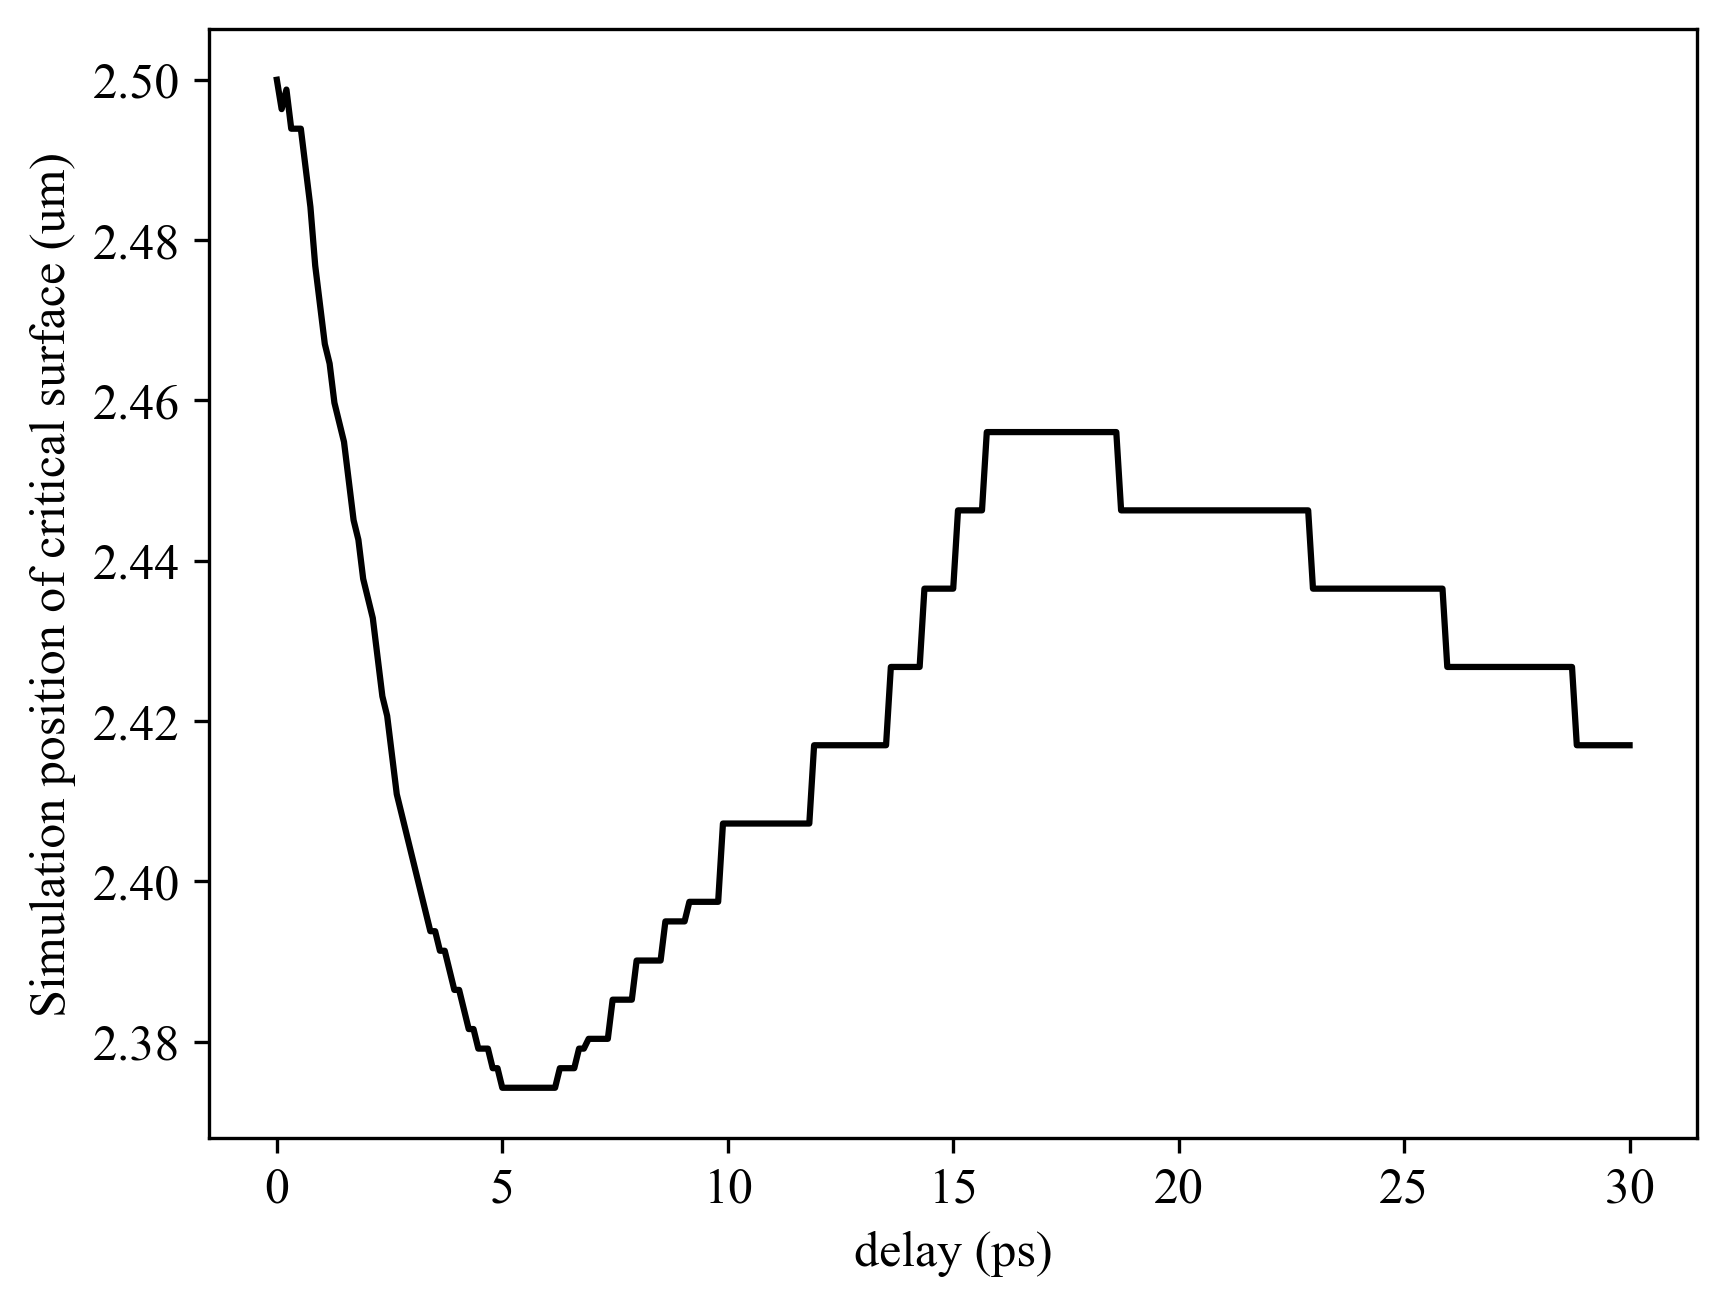

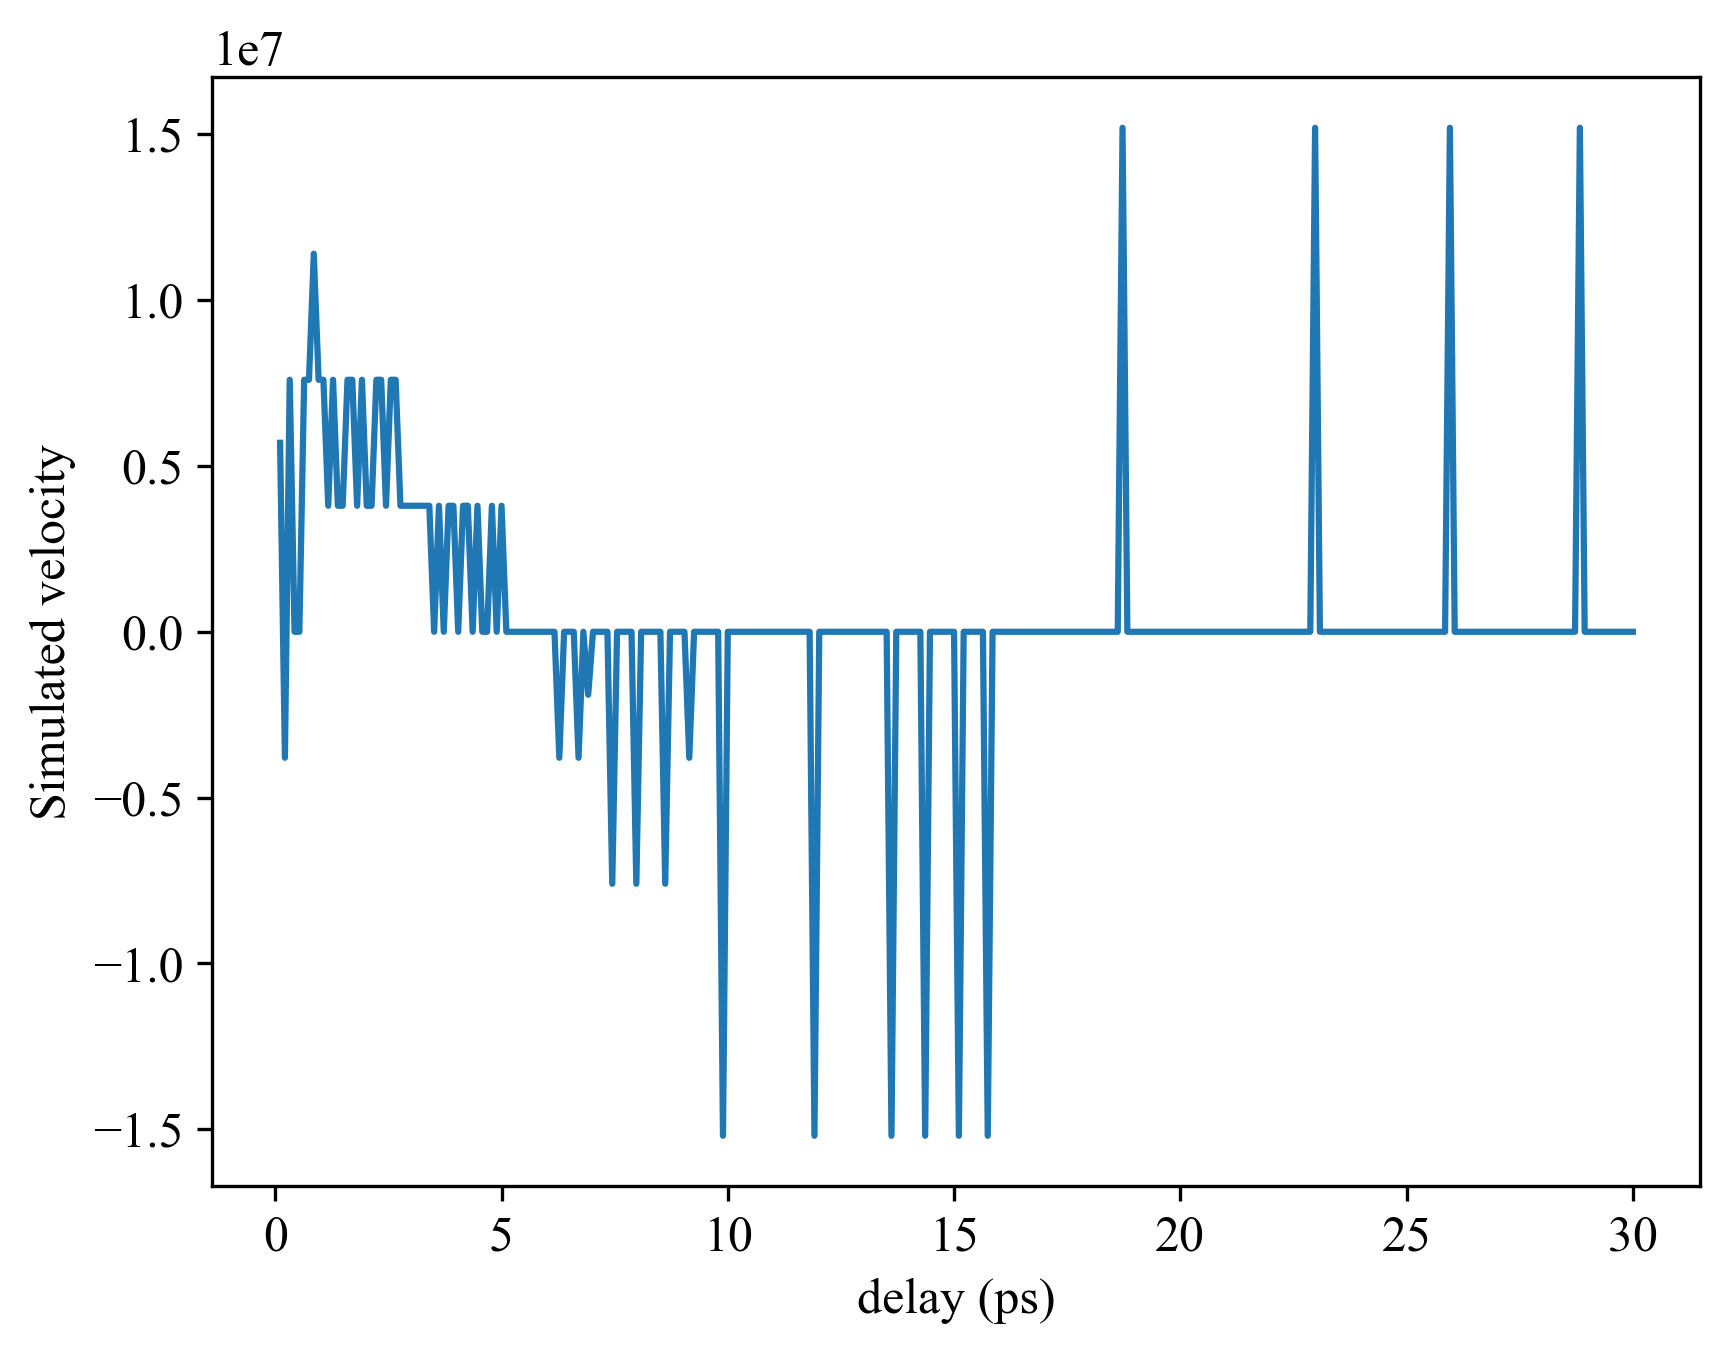

In [52]:
pos[0] = 0.00025*1e4
# pos = np.array(pos)-pos[0]
t = np.linspace(0,30,len(pos))

plt.plot(t,pos,"k-")
plt.xlabel("delay (ps)")
plt.ylabel("Simulation position of critical surface (um)")
plt.show()

dt = 1e-13
vel_sim = -1e-4*np.diff(pos)/dt*1.556   # 1/cos(50) = 1.556 as the simulation was done on 50 degree AOI and velocity calculated along that angle
plt.plot(t[1:],vel_sim)
plt.xlabel("delay (ps)")
plt.ylabel("Simulated velocity")
plt.show()




true_delay = t[1:][vel_sim!=0]
true_vel = vel_sim[vel_sim!=0]

C:\Users\mrsag\AppData\Local\Temp\ipykernel_45812\1098567715.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(blue_delay, blue_v, 'ro', color="brown", label="Expt")


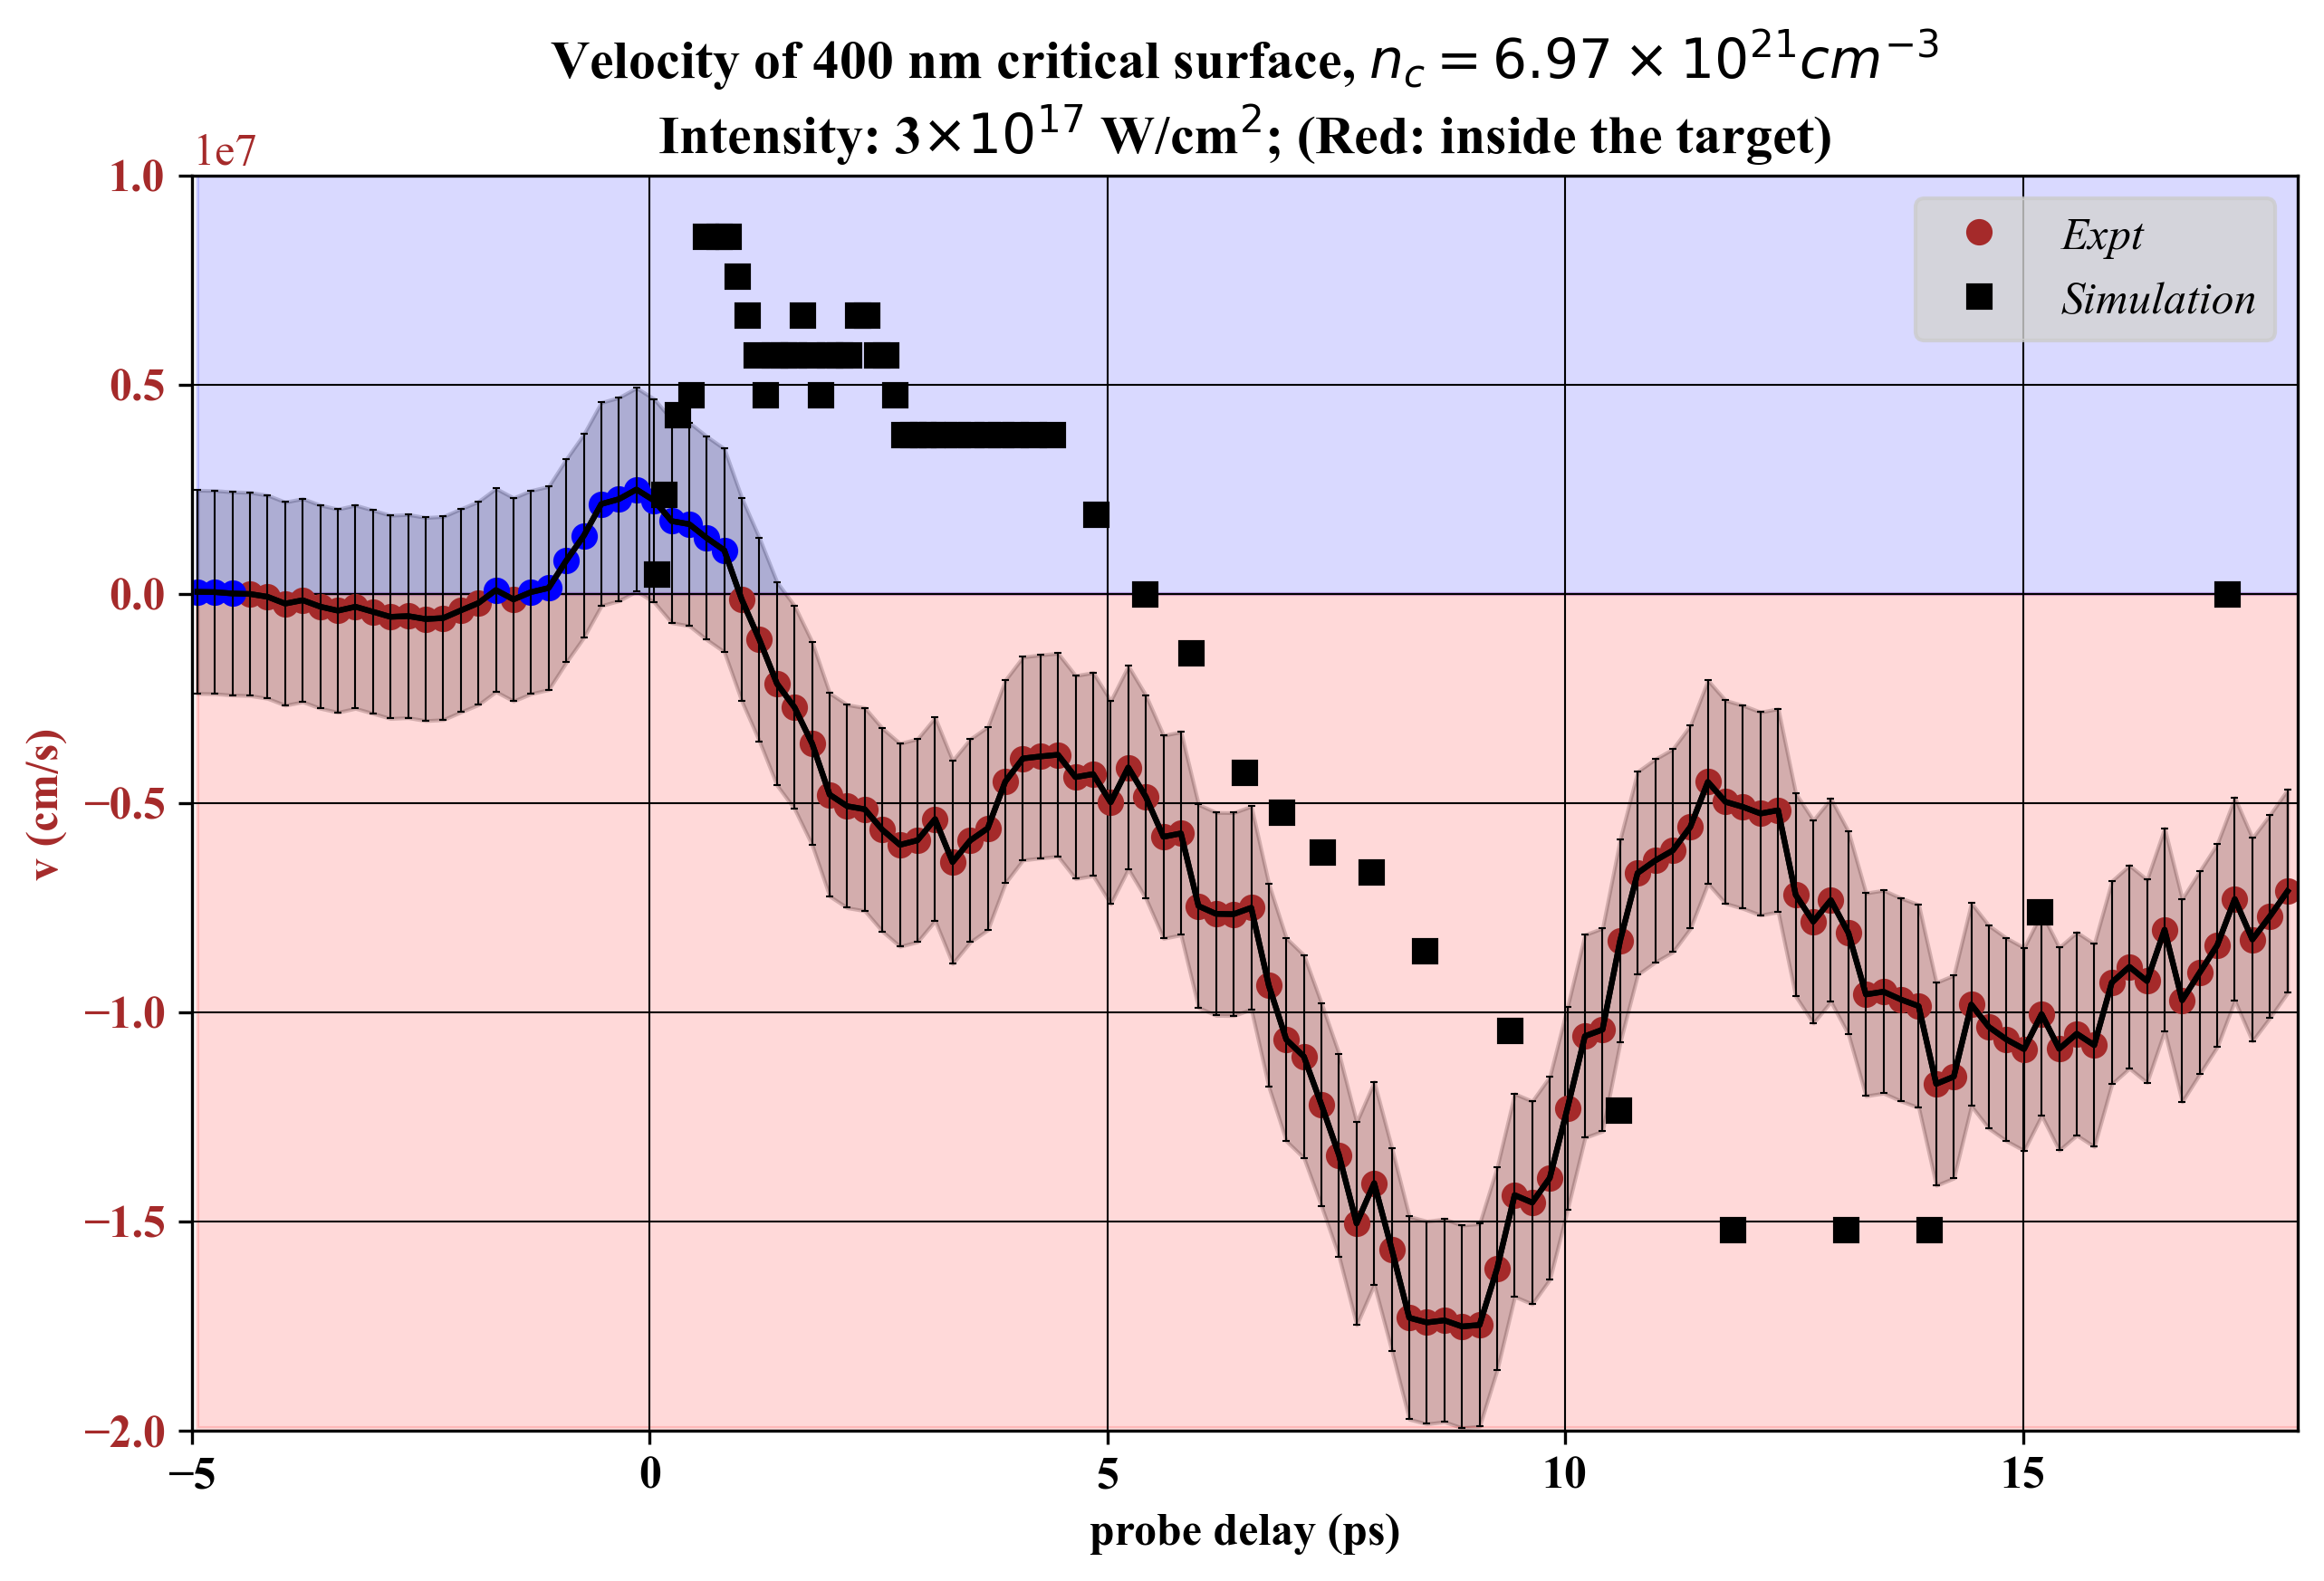

C:\Users\mrsag\AppData\Local\Temp\ipykernel_45812\1098567715.py:94: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(blue_delay, blue_v, 'ro', color="brown", label="Expt", markersize=10)


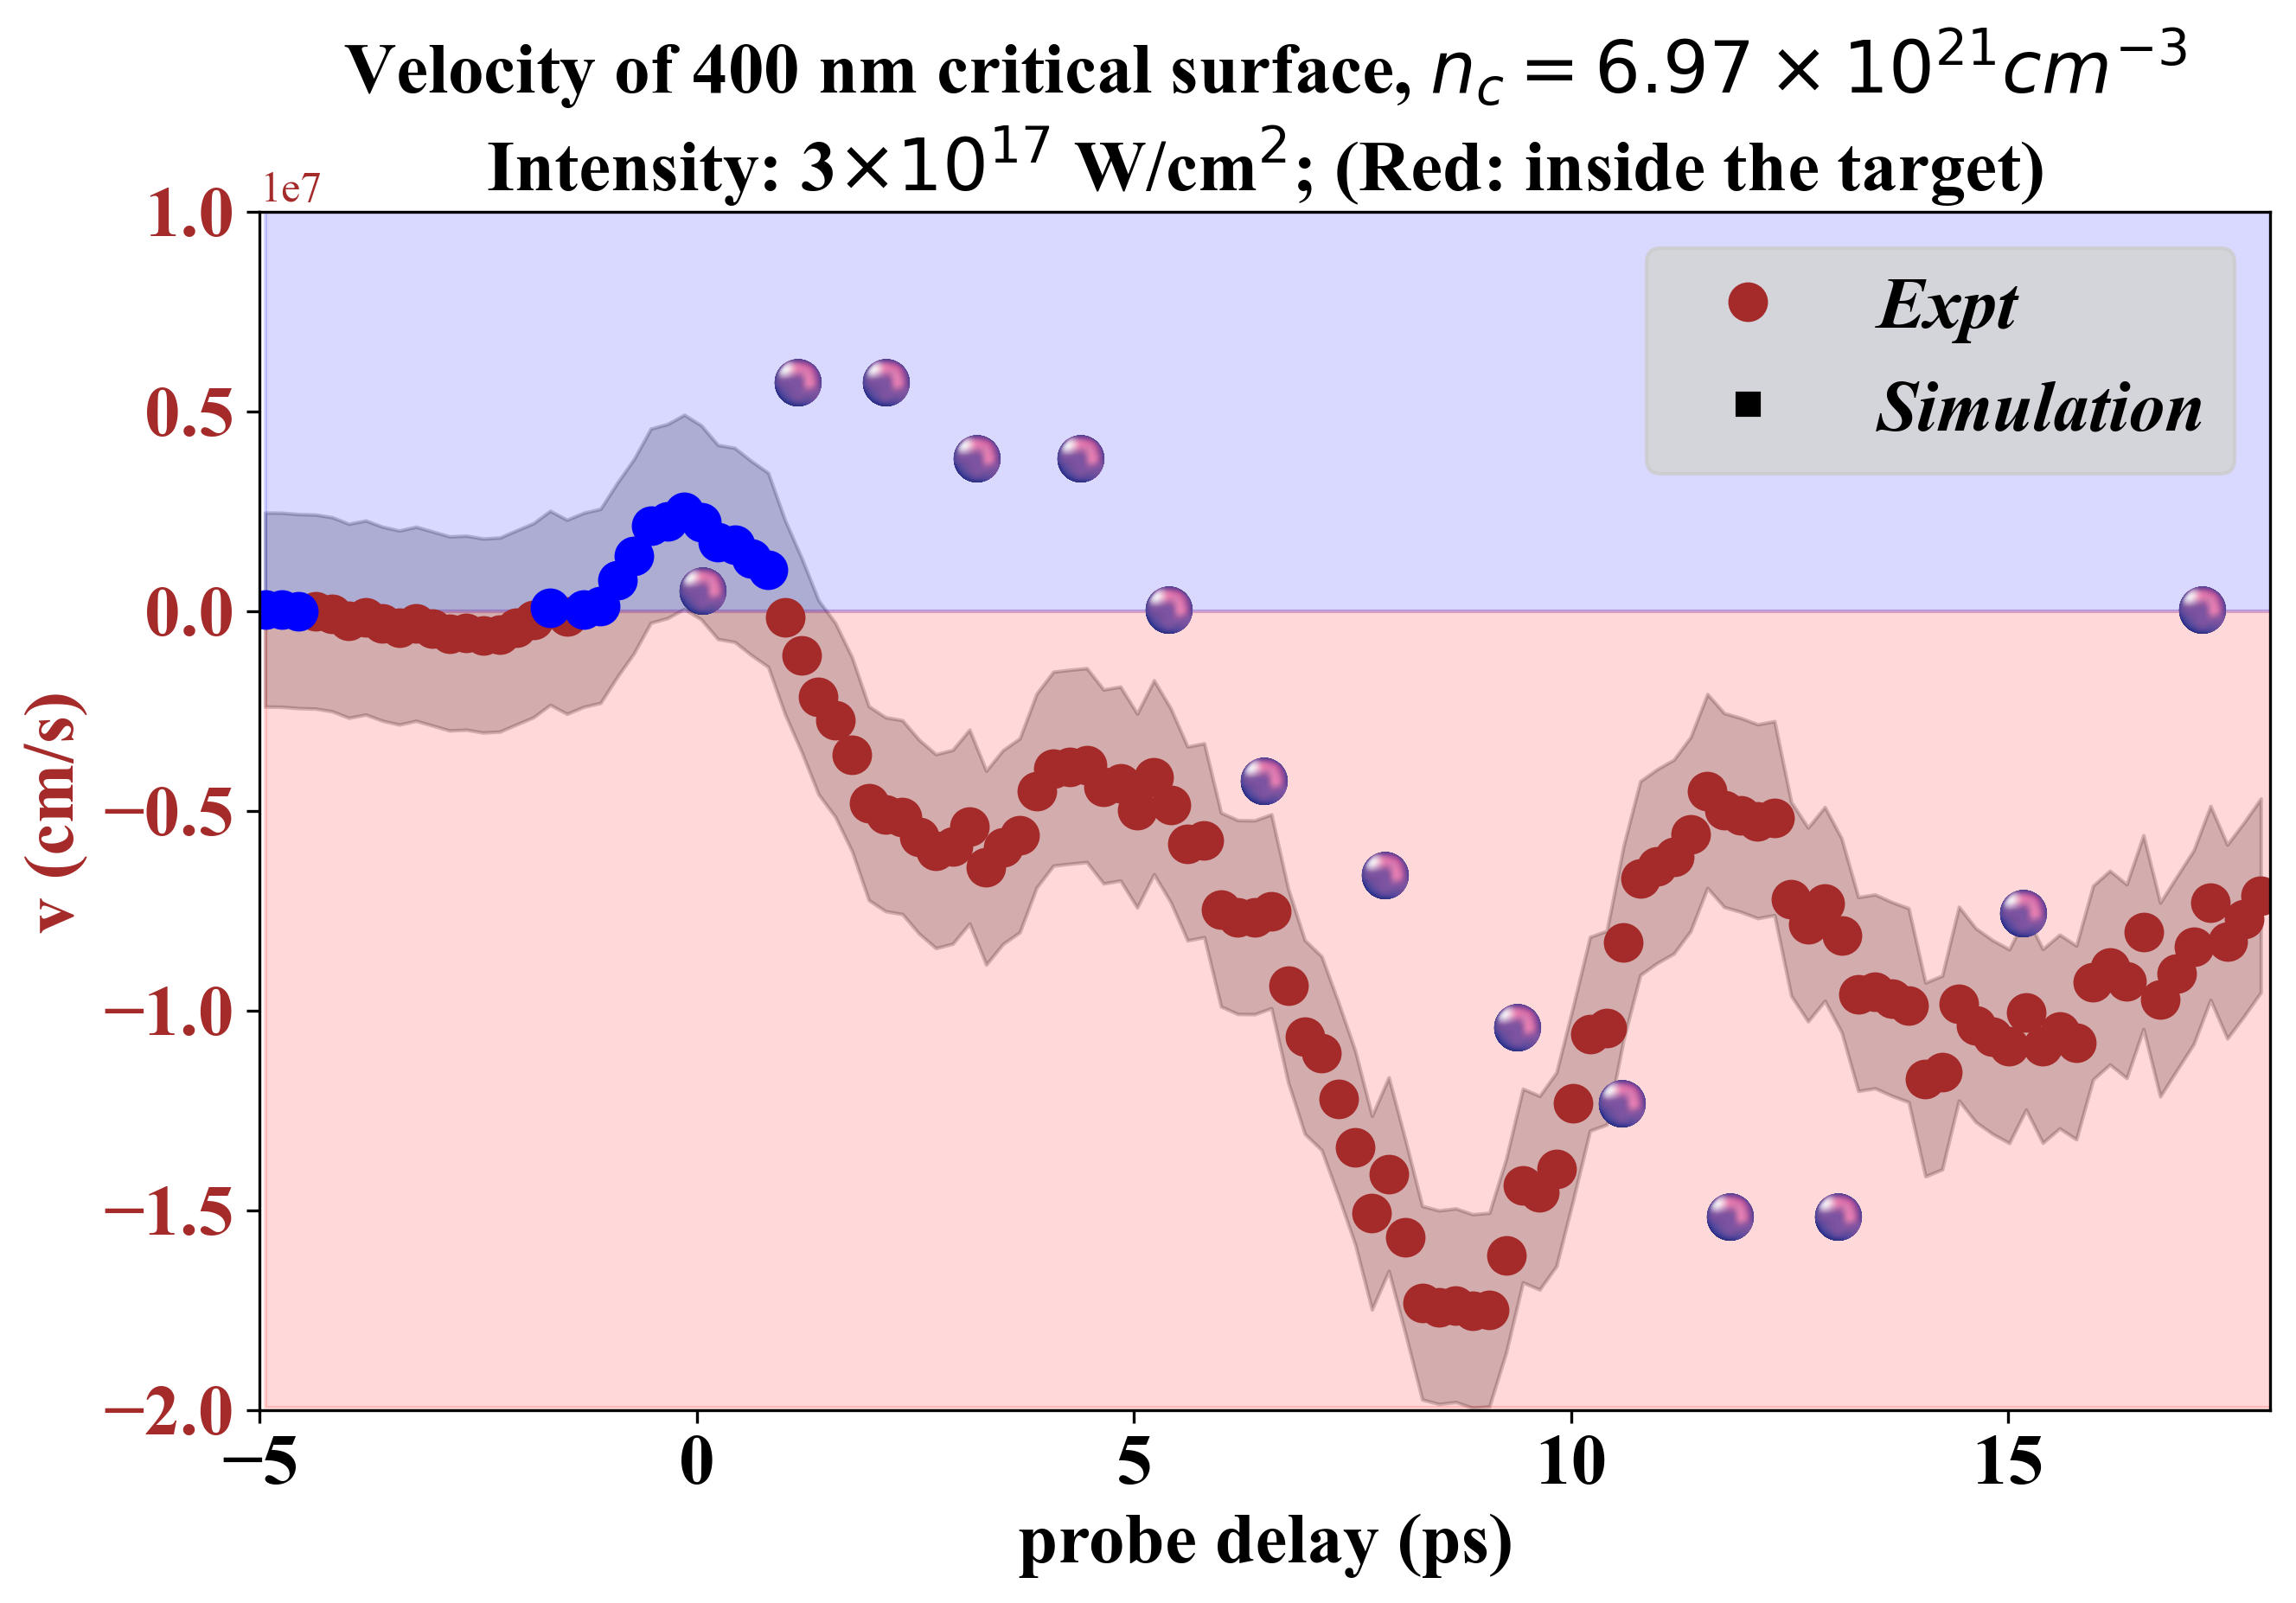

In [53]:
# Full enhanced plot with bold formatting

plt.figure(figsize=(10,6))
plt.plot(blue_delay, blue_v, 'ro', color="brown", label="Expt")
plt.plot(red_delay, red_v, 'bo')
plt.plot(delay, velocity, 'k-')
plt.errorbar(
    x=delay, 
    y=np.array(velocity), 
    yerr=[v_lerr, v_uerr], 
    elinewidth=0.5, 
    capsize=1, 
    capthick=0.5, 
    color='k'
)

# Title (bold)
plt.title(
    "Velocity of 400 nm critical surface, " + r"$n_c=6.97\times 10^{21} cm^{-3}$" + "\n" +
    fr"Intensity: 3$\times$" + r"$10^{17}$ W/cm$^2$" + "; (Red: inside the target)", 
    fontweight='bold'
)

# Axis labels (bold)
plt.xlabel("probe delay (ps)", fontweight='bold')
plt.ylabel(r"v (cm/s)", color='brown', fontweight='bold')

# Tick label color & weight
plt.tick_params(axis='y', labelcolor='brown')
plt.setp(plt.gca().get_xticklabels(), fontweight='bold')
plt.setp(plt.gca().get_yticklabels(), fontweight='bold')

# Axis limits
plt.xlim(-5, 18)
plt.ylim(-2e7, 1.0e7)

# Data shading and fill
plt.fill_between(delay, velocity + v_uerr, velocity - v_lerr, color="k", alpha=0.2)
plt.plot(
    moving_average(true_delay, 4) * 0.95,
    moving_average(true_vel, 4),
    marker="s",
    color="k",
    label="Simulation",
    lw=0
)

# Background shading
x = np.linspace(min(delay), 30, 100)
y1 = np.ones(len(x)) * (max(true_vel))
y2 = np.ones(len(x)) * (min(velocity) - min(v_lerr))

plt.fill_between(x, y2, where=(y2 <= 0), color='red', alpha=0.15)
plt.fill_between(x, y1, where=(y1 > 0), color='blue', alpha=0.15)

# Legend formatting
legend = plt.legend(facecolor="lightgray")
for text in legend.get_texts():
    # text.set_fontweight('bold')
    text.set_fontstyle('italic')

# Grid
plt.grid(lw=0.5, color="black")

# Show plot
plt.show()

x = moving_average(true_delay, 4)*0.95
y = moving_average(true_vel, 4)

y = y[0:find_index(x,18.5)]
x = x[0:find_index(x,18.5)]


# Threshold for spacing
min_spacing = 1

# Filtering logic
filtered_x = [x[0]]
filtered_y = [y[0]]
last_x = x[0]

for i in range(1, len(x)):
    if abs(x[i] - last_x) >= min_spacing:
        filtered_x.append(x[i])
        filtered_y.append(y[i])
        last_x = x[i]


# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data
ax.plot(blue_delay, blue_v, 'ro', color="brown", label="Expt", markersize=10)
ax.plot(red_delay, red_v, 'bo', markersize=10)
# ax.plot(delay, velocity, 'k-')

# Axis labels (bold)
ax.set_xlabel("probe delay (ps)", fontweight='bold', fontsize=20)
ax.set_ylabel(r"v (cm/s)", color='brown', fontweight='bold', fontsize=20)

# Title (bold)
ax.set_title(
    "Velocity of 400 nm critical surface, " + r"$n_c=6.97\times 10^{21} cm^{-3}$" + "\n" +
    fr"Intensity: 3$\times$" + r"$10^{17}$ W/cm$^2$" + "; (Red: inside the target)",
    fontweight='bold',
    fontsize=20
)

# Tick label formatting
ax.tick_params(axis='y', labelcolor='brown')
ax.tick_params(axis='both', labelsize=20)
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')

# Error fill
ax.fill_between(delay, velocity + v_uerr, velocity - v_lerr, color="k", alpha=0.2)

# Simulation points
ax.plot(
    filtered_x,
    filtered_y,
    marker="s",
    color="k",
    label="Simulation",
    lw=0
)

# Load your image (replace 'dot_image.png' with your actual image file)
image_path = "C:\\Users\\mrsag\\OneDrive\\Desktop\\3d balls.png"  
dot_image = mpimg.imread(image_path)

# Function to create image markers
def image_scatter(x, y, image, ax, zoom=0.2):
    for (x0, y0) in zip(x, y):
        im = OffsetImage(image, zoom=zoom)  # Adjust zoom for size
        ab = AnnotationBbox(im, (x0, y0), frameon=False)
        ax.add_artist(ab)
        # ax.plot(x,y,'ko')
        
# Scatter plot using images
image_scatter(filtered_x[:-2], filtered_y[:-2], dot_image, ax, zoom=0.04)

# Background shading
x = np.linspace(min(delay), 30, 100)
y1 = np.ones(len(x)) * max(true_vel)
y2 = np.ones(len(x)) * (min(velocity) - min(v_lerr))

ax.fill_between(x, y2, where=(y2 <= 0), color='red', alpha=0.15)
ax.fill_between(x, y1, where=(y1 > 0), color='blue', alpha=0.15)

# Legend
legend = ax.legend(facecolor="lightgray", fontsize=20)
for text in legend.get_texts():
    text.set_fontweight('bold')
    text.set_fontstyle('italic')
    
    

# Axis limits
ax.set_xlim(-5,18)
ax.set_ylim(-2e7, 1.0e7)

# Optional grid
# ax.grid(lw=0.5, color="black")

# Show plot
plt.show()
